In [1]:
%load_ext autoreload
%autoreload 3



In [2]:
from engine import *
from diffusion import *

from matplotlib import pyplot as plt

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [3]:
import controlled_multi

In [4]:
import torch.distributed as dist



dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                world_size=args.world_size, rank=args.rank,
                                timeout=datetime.timedelta(minutes=1))

In [5]:
skretch = gen_metropolis(50)

skretch = add_skies(skretch, 4, Z = 200)

In [ ]:
resolution = 256

In [6]:
verbose = 0
linewidth = 0
pov = Point(0,0,12)
direction = Point(1,1,-0.1)
vision_angle = 35

sc1 = Scene(skretch, pov, direction, resolution = (resolution,resolution), vision_angle = 35, verbose = verbose, linewidth = linewidth)

# seg_map = sc1.get_seg_map()
# print(seg_map.shape)

# plt.imshow(seg_map)

In [7]:
pov = Point(0,10,40)
direction = Point(1,0.9,-0.1)
sc2 = Scene(skretch, pov, direction, resolution = (resolution,resolution), vision_angle = 35, verbose = verbose, linewidth = linewidth)
# seg_map = sc2.get_seg_map()
# print(seg_map.shape)
# plt.imshow(seg_map)

In [8]:

##prompt = "a farm"

device = "cuda"
model = "deliberate"
control = ['seg','normal']
##control = ['seg']

pipe = controlled_multi.MultiDiffusion(device, control, sc1, sc2, model=model , hf_key=None)

[INFO] loading stable diffusion...


text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[INFO] pairing scenes
[INFO] loaded stable diffusion!


In [10]:
prompt = "a cyberpunk city. Neon lighting, Dark skies. Epic realistic, (hdr:1.4), (muted colors:1.4), apocalypse, abandoned, screen space refractions, (intricate details), (intricate details, hyperdetailed:1.4), artstation, vignette"
nprompt = "blurry, foggy"
image1, image2 = pipe(prompt = prompt, negative_prompt = nprompt, num_inference_steps = 400, 
                      pairing_strength = 0.5, max_pairing_steps = 350, display_every= -1, guidance_scale = 9.0,
                      controlnet_conditioning_scale = [1.0, 0.3])

  0%|          | 0/400 [00:00<?, ?it/s]

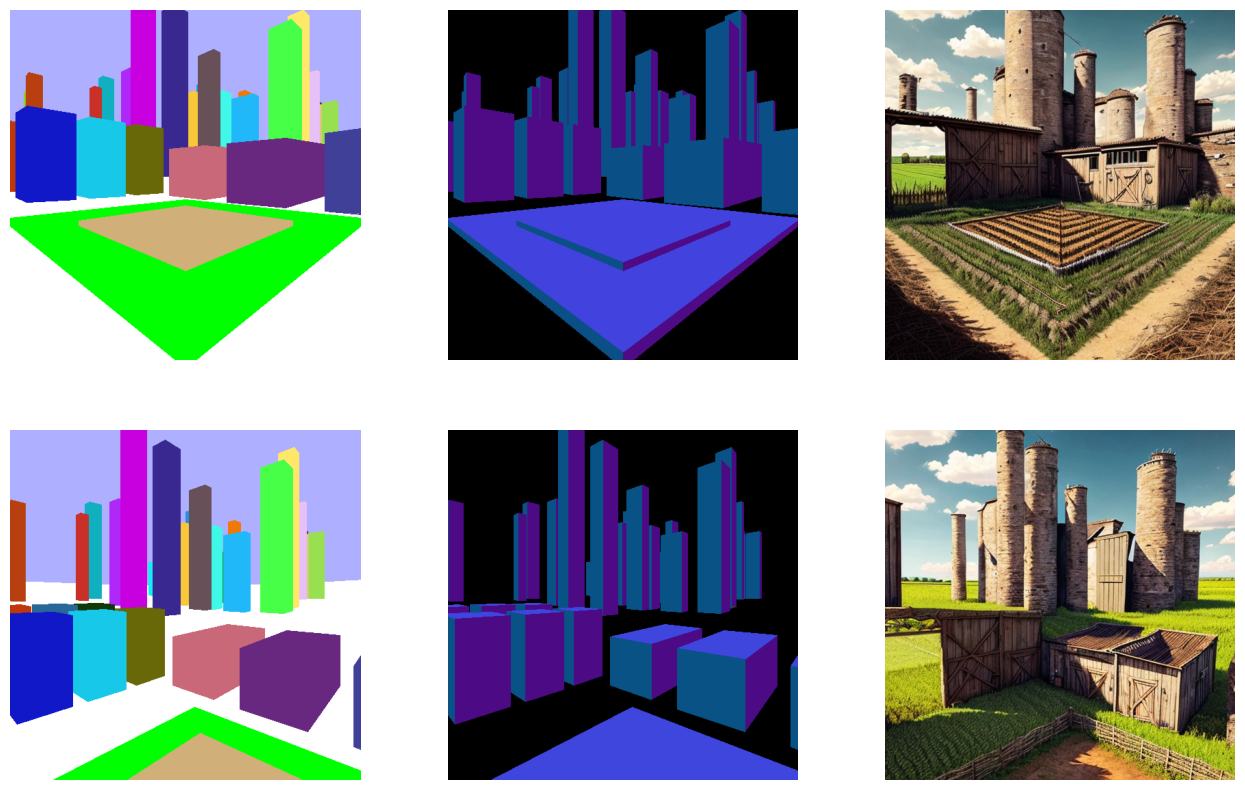

In [11]:
src = [[sc.get_seg_map(),sc.get_norm_map()] for sc in [sc1,sc2]] 
results = [np.asarray(image1), np.asarray(image2)]

present(src, results)

In [7]:
%debug

> /home/yaniv/self_consistent_3d_to_2d/controlled_multi.py(158)__init__()
    156         new_map1 = []
    157         new_map2 = []
--> 158         for i in range(map1.size(1)):
    159             val1 = tuple(map1[:,i])
    160             val2 = tuple(map2[:,i])



ipdb>  map1


array([[ 0,  0,  0, ..., 22, 47, 43],
       [ 2,  2,  2, ..., 47, 14,  7]])


ipdb>  map1.size(1)


*** TypeError: 'int' object is not callable


ipdb>  len(map1)


2


ipdb>  type(map1)


<class 'numpy.ndarray'>


ipdb>  map1.shape


(2, 94730)


ipdb>  map1.shape[1]


94730


ipdb>  q


In [ ]:
plt.imshow(image[0])

In [78]:
map1 = (np.random.randn(2,16)*2).to(dtype=torch.int)
map2 = (torch.randn(2,16)*2).to(dtype=torch.int)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 map1 = (np.random.randn(2,16)*2).to(dtype=torch.int)                                         │
│   2 map2 = (torch.randn(2,16)*2).to(dtype=torch.int)                                             │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [37]:
map1

tensor([[ 1,  2, -4, -1,  0, -1,  2, -3,  2,  2,  0,  1,  0, -2,  0,  1],
        [-1,  3,  0, -1, -1,  0, -1,  0,  0, -2,  0,  0,  0,  1,  0,  0]],
       dtype=torch.int32)

In [38]:
map2

tensor([[ 0,  0,  0,  0,  0, -2,  0, -1,  2, -1,  0,  2, -2,  0,  2,  0],
        [-1,  1, -1,  0, -2,  0, -1,  0,  3, -1, -2,  1,  3,  1,  2,  1]],
       dtype=torch.int32)

In [91]:
new_map1 = []
new_map2 = []
for i in range(map1.size(1)):
    val1 = tuple(map1[:,i])
    val2 = tuple(map2[:,i])
    if not val1 in new_map1 and not val2 in new_map2:
        new_map1.append(val1)
        new_map2.append(val2)
        
map1 = np.asarray(new_map1).transpose()
map2 = np.asarray(new_map2).transpose()

In [92]:
map1

array([[ 1,  2, -1,  0, -1, -3,  2,  2,  1,  0],
       [-1,  3, -1, -1,  0,  0,  0, -2,  0,  0]], dtype=int32)

In [93]:
map2

array([[ 0,  0,  0,  0, -2, -1,  2, -1,  2, -2],
       [-1,  1,  0, -2,  0,  0,  3, -1,  1,  3]], dtype=int32)

In [54]:
map1_un = np.unique(map1, axis = 1)

In [61]:
for u in map1_un.transpose():
    print(u)

[-4  0]
[-3  0]
[-2  1]
[-1 -1]
[-1  0]
[ 0 -1]
[0 0]
[ 1 -1]
[1 0]
[ 2 -2]
[ 2 -1]
[2 0]
[2 3]


In [41]:
inv

array([ 7, 12,  0,  3,  5,  4, 10,  1, 11,  9,  6,  8,  6,  2,  6,  8])

In [31]:
np.arange(map1.shape[1])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
prompt = "a countryside farm. Bright skies. Epic realistic, (hdr:1.4), (muted colors:1.4), abandoned, (intricate details), (intricate details, hyperdetailed:1.4), artstation, vignette"
device = "cuda"
model = "realistic"
control = ["seg"]
steps = 200

stamped_img, src = run_diffusion(sc1 , device = device, prompt = prompt, model = model, control = control, steps = steps)

In [ ]:
model_id_or_path = get_model_path(model)


In [ ]:
controlnets, mconds = get_controls(control, sc1)

In [ ]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(model_id_or_path, controlnet=controlnets, safety_checker=None, torch_dtype=torch.float16)

In [ ]:
sc1.transition(sc2, intensity = 1.0)

src = [[sc.get_seg_map()] for sc in [sc1,sc2]] 
results = [sc.get_image() for sc in [sc1,sc2]]

present(src, results)

In [ ]:
def run_inpainting(scene , device = "cuda", prompt = None, model = "realistic", control = "seg", steps = 200, strength = 1.0):
    if prompt is None:
        prompt = "a countryside farm. Epic realistic, (hdr:1.4), (muted colors:1.4), abandoned, (intricate details), (intricate details, hyperdetailed:1.4), artstation, vignette"

    model_id_or_path = get_model_path(model)

    controlnets, mconds = get_controls(control, scene)

    # pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    #     model_id_or_path, controlnet=controlnets, safety_checker=None, torch_dtype=torch.float16
    # )
    
    pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
        model_id_or_path, controlnet=controlnets, safety_checker=None, torch_dtype=torch.float16
    )

    pipe = pipe.to(device)

    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

    pipe.enable_xformers_memory_efficient_attention()

    pipe.enable_model_cpu_offload()

    start_image = scene.get_image()

    mask = (np.where(start_image == (0,0,0), 1, 0).sum(2)==3)
    
    ##mask = np.float32(mask)
    
    # kernel = np.ones((3,3),np.float)
    # mask = cv2.dilate(mask,kernel,iterations = 1)
    # import pdb; pdb.set_trace()
    
    mask = mask.astype(np.uint8)

    plt.imshow(mask)
    plt.show()

    
    image = pipe(prompt, image=start_image, mask_image=mask, control_image= mconds, 
                         strength = strength, num_inference_steps=steps,
                         height=1024, width=1024).images[0]

    stamp_image = np.asarray(image)

    ##scene.set_image(stamp_image)


    return stamp_image, mconds

In [ ]:
stamped_img, src = run_inpainting(sc2 , device = device, prompt = prompt, model = model, control = control, steps = 100, strength = 1.0)

src = [[sc.get_seg_map()] for sc in [sc1,sc2]] 
results = [sc.get_image() for sc in [sc1,sc2]]

present(src, results)

In [ ]:
# def run_refine(scene , device = "cuda", prompt = None, steps = 200, strength = 1.0):
#     if prompt is None:
#         prompt = "a countryside farm. Epic realistic, (hdr:1.4), (muted colors:1.4), abandoned, (intricate details), (intricate details, hyperdetailed:1.4), artstation, vignette"

#     pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
#         "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
#     )

#     pipe = pipe.to(device)

#     pipe.enable_xformers_memory_efficient_attention()

#     pipe.enable_model_cpu_offload()

#     start_image = scene.get_image()

#     ##import pdb; pdb.set_trace()

#     image = pipe(prompt, image=start_image, strength = strength, 
#                          num_inference_steps=steps, ).images[0]

#     output_image = np.asarray(image)

#     scene.set_image(output_image)

#     return stamp_image

def run_img2img(scene , device = "cuda", prompt = None, model = "realistic", control = "seg", steps = 200, strength = 1.0):
    if prompt is None:
        prompt = "a countryside farm. Epic realistic, (hdr:1.4), (muted colors:1.4), abandoned, (intricate details), (intricate details, hyperdetailed:1.4), artstation, vignette"

    model_id_or_path = get_model_path(model)

    controlnets, mconds = get_controls(control, scene)

    pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
        model_id_or_path, controlnet=controlnets, safety_checker=None, torch_dtype=torch.float16
    )
    
    # pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    #     model_id_or_path, controlnet=controlnets, safety_checker=None, torch_dtype=torch.float16
    # )

    pipe = pipe.to(device)

    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

    pipe.enable_xformers_memory_efficient_attention()

    pipe.enable_model_cpu_offload()

    start_image = scene.get_image()

    image = pipe(prompt, image=start_image, control_image= mconds, 
                         strength = strength, num_inference_steps=steps,
                         height=1024, width=1024).images[0]
    
    stamp_image = np.asarray(image)

    print("before:")
    plt.imshow(start_image)
    plt.show()
    print("stamp image shape: ", stamp_image.shape)
    plt.imshow(stamp_image)
    plt.show()

    ##scene.set_image(stamp_image)

    return stamp_image, mconds




run_img2img(sc2 , device = device, prompt = prompt, steps = 800, strength = 0.5, model = "realistic", control = ["seg"])

src = [[sc.get_seg_map()] for sc in [sc1,sc2]] 
results = [sc.get_image() for sc in [sc1,sc2]]

present(src, results)